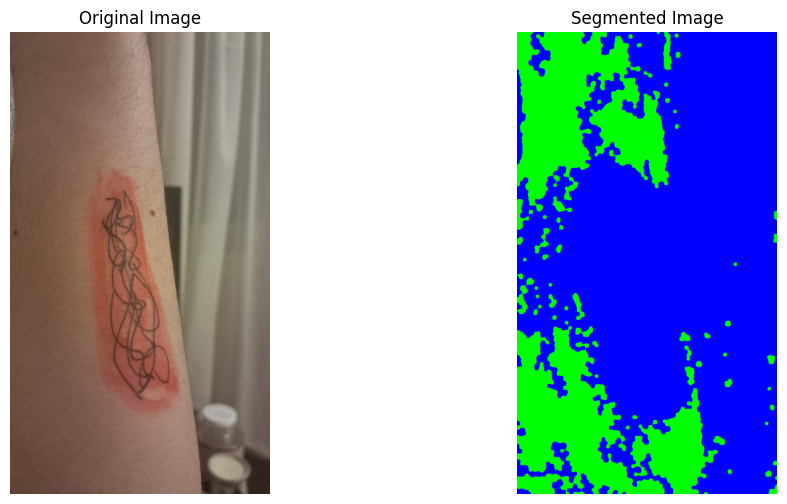

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, transform, morphology
from scipy.ndimage import gaussian_filter, binary_fill_holes
from sklearn.cluster import KMeans
import cv2

# Load images
image_path = 'actual.jpeg'  # Image containing burn, healthy skin, and background
reference_path = 'reference.jpeg'  # Reference cropped healthy skin

image = img_as_float(io.imread(image_path))
reference_image = img_as_float(io.imread(reference_path))

# Convert to LAB color space
image_lab = color.rgb2lab(image)
reference_lab = color.rgb2lab(reference_image)

# Adaptive Illumination Correction
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
image_lab[:,:,0] = clahe.apply((image_lab[:,:,0] * 255).astype(np.uint8)) / 255.0

# Gaussian filtering
sigma_value = 1.5
image_lab_filtered = np.zeros_like(image_lab)
for i in range(3):
    image_lab_filtered[:, :, i] = gaussian_filter(image_lab[:, :, i], sigma=sigma_value)

# Extract mean LAB color from reference skin
healthy_skin_mean = np.mean(reference_lab.reshape(-1, 3), axis=0)

# Compute color distance to reference skin
color_diff = np.linalg.norm(image_lab.reshape(-1, 3) - healthy_skin_mean, axis=1)
color_diff = color_diff.reshape(image.shape[:2])

# Threshold to identify healthy skin (adjustable threshold)
skin_mask = color_diff < np.percentile(color_diff, 50)  # Lower percentile → tighter skin selection

# Morphological processing to refine the skin mask
skin_mask = morphology.binary_opening(skin_mask, morphology.disk(5))
skin_mask = morphology.binary_closing(skin_mask, morphology.disk(5))
skin_mask = binary_fill_holes(skin_mask)  # Ensure enclosed regions are filled

# Identify the burn as the region enclosed by healthy skin
labels, num_labels = morphology.label(~skin_mask, return_num=True, connectivity=2)
burn_mask = np.zeros_like(skin_mask)

for i in range(1, num_labels + 1):
    region = labels == i
    if np.all(skin_mask[region]):  # If surrounded by healthy skin
        burn_mask[region] = 1

# Generate segmentation visualization
segmentation_map = np.zeros((image.shape[0], image.shape[1], 3))
segmentation_map[skin_mask] = [0, 1, 0]  # Green for healthy skin
segmentation_map[burn_mask] = [1, 0, 0]  # Red for burn
segmentation_map[~skin_mask & ~burn_mask] = [0, 0, 1]  # Blue for background

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title('Segmented Image')
plt.axis('off')
plt.show()
